# ARIMA for the GDP of Ecuador

**Author:** Pablo Estrada


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

First, we will download the real GDP data of Ecuador from [here](https://contenido.bce.fin.ec/home1/estadisticas/cntrimestral/CNTrimestral.jsp) (constant dollars of 2007) and get the t/t-1 quarterly growth rate of real GDP from the first quarter of 2000 to the fourth quarter of 2019. Using different values for $p$ and $q$, we will determine the optimal model for the growth rate of real GDP.

Then, obtain the AIC, BIC, HQ information criteria from a set of models with a large number of lags (ranging from 1 to 4) and a large number of moving average components (ranging from 1 to 2) and all their combinations (there are 8 cases in total).

In [2]:
df = pd.read_excel("data/ecu_gdp.xlsx", parse_dates=["quarter"])
df["lgdp"] = np.log1p(df["gdp"])

In [3]:
res_dict = {}
for p in range(1, 5):
    for q in range(1, 3):
        y = df["lgdp"].diff(4) * 100
        model = ARMA(y, order=(p,q), missing="drop", dates=df["quarter"])
        results = model.fit()
        row = [p, q, results.aic, results.bic, results.hqic]
        res_dict[f"{p}-{q}"] = row
        
pd.DataFrame.from_dict(res_dict, orient="index", columns=["p", "q", "AIC", "BIC", "HQ"])

,p,q,AIC,BIC,HQ
1-1,1,1,267.120812,276.443746,270.846708
1-2,1,2,257.675978,269.329645,262.333347
2-1,2,1,262.641140,274.294807,267.298509
2-2,2,2,250.934061,264.918461,256.522904
3-1,3,1,263.712317,277.696717,269.301160
3-2,3,2,251.478139,267.793272,257.998455
4-1,4,1,252.357965,268.673099,258.878282
4-2,4,2,249.156379,267.802245,256.608169


- Among the 8 models, select the model with the lowest information criterion.

In [4]:
df["growth"] = df["gdp"].pct_change(4) * 100
y = df["growth"].iloc[1:]
model = ARIMA(y, order=(2,0,2), dates=df["quarter"])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   79
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -122.229
Date:                Tue, 31 Aug 2021   AIC                            256.458
Time:                        17:24:27   BIC                            270.674
Sample:                             0   HQIC                           262.153
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5090      0.747      4.696      0.000       2.045       4.973
ar.L1          1.0136      0.154      6.586      0.000       0.712       1.315
ar.L2         -0.3636      0.136     -2.667      0.008      -0.631      -0.096
ma.L1          0.0360      0.091      0.395      0.693      -0.143       0.215
ma.L2          0.8603      0.064     13.370      0.000       0.734       0.986
sigma2         1.3771      0.220      6.259      0.000       0.946       1.808
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 6.19
Prob(Q):                              0.65   Prob(JB):                         0.05
Heteroskedasticity (H):               0.77   Skew:                             0.23
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
prediction = results.get_prediction(76, 79)
y_pred = pd.Series(prediction.predicted_mean)
# Get confidence intervals of forecasts
prediction_ci = prediction.conf_int()
prediction_ci.index = y[-4:].index
# Get RMSE
rmse = np.sqrt(mean_squared_error(y[-4:].values, y_pred))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 0.41


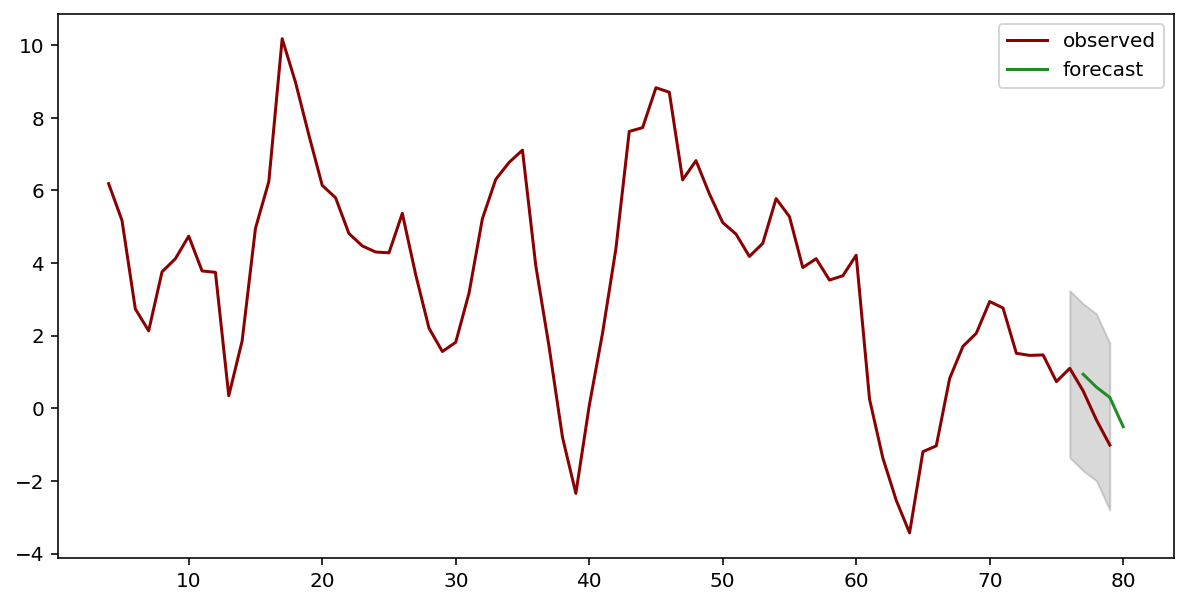

In [6]:
ax = y.plot(label='observed', figsize=(10, 5), color="darkred")
y_pred.plot(ax=ax, label='forecast', color="forestgreen")
ax.fill_between(prediction_ci.index,
                prediction_ci.iloc[:, 0],
                prediction_ci.iloc[:, 1], color='k', alpha=.15)
plt.legend()
plt.show()